In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.covariance import LedoitWolf

# Data fetching
# Custom data fetcher to replace broken YahooDataProvider
# The qiskit-finance YahooDataProvider has compatibility issues with latest yfinance
import yfinance as yf

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Extract data

In [2]:
# Portfolio parameters
# Data parameters
START_DATE = datetime.now() - timedelta(days=365*2)  # 2 years of data
END_DATE = datetime.now()

# S&P 500 stocks (diversified sector selection)
TICKERS = [
    # Technology
    'NVDA',  # NVIDIA
    'MSFT',  # Microsoft
    'AAPL',  # Apple
    'AMZN',  # Amazon
    'META',  # Meta
    'AVGO',  # Broadcom
    'GOOGL', # Alphabet
    'TSLA',  # Tesla
    'BRK-B', # Berkshire Hathaway
    'WMT',   # Walmart
]


print(f"Configuration:")
print(f"  Tickers: {TICKERS}")
print(f"  Date range: {START_DATE.date()} to {END_DATE.date()}")

Configuration:
  Tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'BRK-B', 'WMT']
  Date range: 2023-11-03 to 2025-11-02


In [3]:
def fetch_stock_data(tickers, start_date, end_date):
    """
    Fetch stock data and compute returns, covariance, and correlation.

    Args:
        tickers: List of ticker symbols
        start_date: Start date
        end_date: End date

    Returns:
        mean_returns, covariance_matrix, daily_returns, prices
    """
    print(f"Fetching data for {len(tickers)} stocks from Yahoo Finance...")

    # Download data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)

    # Extract adjusted close prices
    if len(tickers) == 1:
        prices = data['Adj Close'].to_frame()
        prices.columns = tickers
    else:
        prices = data['Adj Close']

    # Drop any NaN values
    prices = prices.dropna()

    print(f"Downloaded {len(prices)} days of price data")

    # Calculate daily returns
    returns = prices.pct_change().dropna()

    # Calculate mean returns (daily)
    mean_returns = returns.mean().values

    # Calculate sample covariance matrix (daily)
    sample_covariance_matrix = returns.cov().values

    return mean_returns, sample_covariance_matrix, returns, prices

mean_returns, covariance_matrix, daily_returns, price_data = fetch_stock_data(
    TICKERS, START_DATE, END_DATE
)

print(f"\nData fetched successfully!")
print(f"Mean returns shape: {mean_returns.shape}")
print(f"Covariance matrix shape: {covariance_matrix.shape}")
print(f"Daily returns shape: {daily_returns.shape}")

Fetching data for 10 stocks from Yahoo Finance...
Downloaded 500 days of price data

Data fetched successfully!
Mean returns shape: (10,)
Covariance matrix shape: (10, 10)
Daily returns shape: (499, 10)


In [4]:
for i, ticker in enumerate(TICKERS):
    print(f"  {ticker}: {mean_returns[i]*252:.2%}")  # Annualized (252 trading days)

  NVDA: 25.89%
  MSFT: 33.42%
  AAPL: 87.09%
  AMZN: 16.80%
  META: 44.05%
  AVGO: 43.62%
  GOOGL: 22.55%
  TSLA: 88.85%
  BRK-B: 56.60%
  WMT: 34.44%


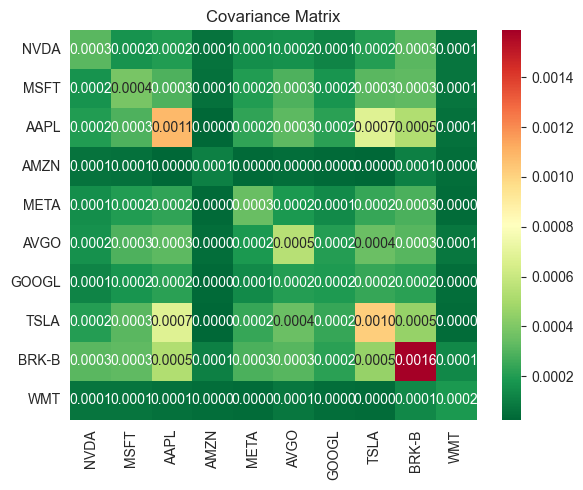

In [5]:
# Visualize covariance matrix - single plot version
plt.figure(figsize=(6, 5))

# Covariance matrix
sns.heatmap(covariance_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r',
            xticklabels=TICKERS, yticklabels=TICKERS)
plt.title('Covariance Matrix')

plt.tight_layout()
plt.show()

In [6]:
covariance_matrix

array([[3.12884938e-04, 1.70058592e-04, 1.98795336e-04, 6.43756032e-05,
        1.49258107e-04, 1.60636195e-04, 1.22793394e-04, 2.05497275e-04,
        3.13814468e-04, 7.25557814e-05],
       [1.70058592e-04, 3.82494059e-04, 2.91347946e-04, 5.61383225e-05,
        1.96720450e-04, 2.91776034e-04, 1.73061416e-04, 3.16934557e-04,
        3.30062413e-04, 7.19960639e-05],
       [1.98795336e-04, 2.91347946e-04, 1.08536380e-03, 2.55582298e-05,
        2.29848420e-04, 3.19301181e-04, 2.15021949e-04, 6.77687232e-04,
        5.27837182e-04, 5.70412647e-05],
       [6.43756032e-05, 5.61383225e-05, 2.55582298e-05, 1.08313251e-04,
        3.35795858e-05, 4.43993926e-05, 3.56302104e-05, 2.84398440e-05,
        1.05614483e-04, 4.42467964e-05],
       [1.49258107e-04, 1.96720450e-04, 2.29848420e-04, 3.35795858e-05,
        3.47996783e-04, 1.86991924e-04, 1.36349356e-04, 2.39926773e-04,
        2.87357283e-04, 3.99766660e-05],
       [1.60636195e-04, 2.91776034e-04, 3.19301181e-04, 4.43993926e-05,
   

# Ledoit-Wolf Function

In [7]:
# Ledoit-Wolf Shrinkage
lw_estimator = LedoitWolf()
lw_estimator.fit(daily_returns)

shrunk_cov_matrix = lw_estimator.covariance_

print("Ledoit-Wolf Estimator")
print(f"Optimal shrinkage coefficient (delta*): {lw_estimator.shrinkage_:.6f}")
print(f"Shrunk covariance matrix shape: {shrunk_cov_matrix.shape}")

Ledoit-Wolf Estimator
Optimal shrinkage coefficient (delta*): 0.045624
Shrunk covariance matrix shape: (10, 10)


In [8]:
shrunk_cov_matrix

array([[3.24296546e-04, 1.61974546e-04, 1.89345236e-04, 6.13153913e-05,
        1.42162850e-04, 1.53000060e-04, 1.16956185e-04, 1.95728587e-04,
        2.98896724e-04, 6.91067097e-05],
       [1.61974546e-04, 3.90596671e-04, 2.77498189e-04, 5.34696848e-05,
        1.87368984e-04, 2.77905927e-04, 1.64834625e-04, 3.01868493e-04,
        3.14372293e-04, 6.85735994e-05],
       [1.89345236e-04, 2.77498189e-04, 1.06005421e-03, 2.43432727e-05,
        2.18922156e-04, 3.04122616e-04, 2.04800488e-04, 6.45472132e-04,
        5.02745477e-04, 5.43297040e-05],
       [6.13153913e-05, 5.34696848e-05, 2.43432727e-05, 1.29449548e-04,
        3.19833188e-05, 4.22887863e-05, 3.39364632e-05, 2.70879040e-05,
        1.00593905e-04, 4.21434441e-05],
       [1.42162850e-04, 1.87368984e-04, 2.18922156e-04, 3.19833188e-05,
        3.57739285e-04, 1.78102921e-04, 1.29867740e-04, 2.28521416e-04,
        2.73697230e-04, 3.80763021e-05],
       [1.53000060e-04, 2.77905927e-04, 3.04122616e-04, 4.22887863e-05,
   

# QUBO formulation

In [14]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

# ---------- Problem Parameters ----------
B = 4                  # cardinality (number of selected assets)
LAMBDA = 5.0           # risk aversion
P_LAYERS = 2           # QAOA depth
SHOTS = 8000           # sampling shots
SEED = 7               # reproducibility
USE_EQUAL_WEIGHT = True

rng = np.random.default_rng(SEED)

# Data from PART 1
mu = mean_returns.copy()            # vector (n,)
Sigma = shrunk_cov_matrix.copy()    # matrix (n,n)
n = len(TICKERS)
assert 1 <= B <= n

# ---------- Classical QUBO ----------
# f(x) = x^T Q x + q^T x with |x|=B; equal weights: w = x/B
if USE_EQUAL_WEIGHT:
    Q = (LAMBDA / (B**2)) * Sigma
    q = -(1.0 / B) * mu
else:
    Q = LAMBDA * Sigma
    q = -mu
Q = 0.5 * (Q + Q.T)  # ensure symmetry

# QAOA Solution

In [15]:
# ---------- QUBO -> Ising (Z) ----------
# x_i = (1 - Z_i)/2 ; x_i x_j = (1 - Z_i - Z_j + Z_iZ_j)/4
def qubo_to_ising(Q, q):
    J = np.zeros((n, n))
    h = np.zeros(n)
    const = 0.0
    for i in range(n):
        for j in range(i+1, n):
            Jij = Q[i, j] / 4.0
            J[i, j] = Jij
            h[i] += -Q[i, j] / 4.0
            h[j] += -Q[i, j] / 4.0
            const += Q[i, j] / 4.0
    for i in range(n):
        h[i] += -(Q[i, i] / 2.0) - (q[i] / 2.0)
        const += (Q[i, i] / 2.0) + (q[i] / 2.0)
    return J, h, const

J, h, const_shift = qubo_to_ising(Q, q)

# ---------- Initial state with |x|=B (RANDOM) ----------
init_idx = rng.choice(n, size=B, replace=False)   # <-- requested change
init_bits = np.zeros(n, dtype=int)
init_bits[init_idx] = 1

# ---------- QAOA ansatz with XY mixer (ring) ----------
def build_qaoa_xy(n, P, J, h, init_bits):
    qc = QuantumCircuit(n, name="QAOA_XY")
    for i, b in enumerate(init_bits):
        if b == 1:
            qc.x(i)

    gammas = [Parameter(f"γ_{k}") for k in range(P)]
    betas  = [Parameter(f"β_{k}") for k in range(P)]

    ring_pairs = [(i, (i+1) % n) for i in range(n)]  # ring connectivity

    for k in range(P):
        γ = gammas[k]
        β = betas[k]
        # Cost: RZ(2γ h_i) + RZZ(2γ J_ij)
        for i in range(n):
            if abs(h[i]) > 1e-15:
                qc.rz(2.0 * γ * h[i], i)
        for i in range(n):
            for j in range(i+1, n):
                if abs(J[i, j]) > 1e-15:
                    qc.append(RZZGate(2.0 * γ * J[i, j]), [i, j])
        # XY mixer (preserves cardinality)
        for (i, j) in ring_pairs:
            qc.append(RXXGate(2.0 * β), [i, j])
            qc.append(RYYGate(2.0 * β), [i, j])
    return qc, gammas + betas

ansatz, theta_params = build_qaoa_xy(n, P_LAYERS, J, h, init_bits)

# ---------- Utilities ----------
def f_qubo(x):
    return float(x @ Q @ x + q @ x)

def bitstr_from_int(k, n):
    return np.array(list(np.binary_repr(k, width=n)), dtype=int)

def bitarray_from_qiskit_string(s):
    # Qiskit returns string little-endian (q_{n-1} ... q_0)
    return np.array(list(s[::-1]), dtype=int)

def bind_params(circ, mapping):
    """Terra compatibility: first try assign_parameters, if not available, bind_parameters."""
    try:
        return circ.assign_parameters(mapping, inplace=False)
    except Exception:
        try:
            return circ.bind_parameters(mapping)
        except Exception as e:
            raise RuntimeError(f"Could not assign parameters: {e}")

# Exact expectation via statevector (diagonal in computational basis)
def expectation_statevector(theta):
    bind = {p: float(t) for p, t in zip(theta_params, theta)}
    circ_b = bind_params(ansatz, bind)
    sv = Statevector.from_instruction(circ_b)
    amps = sv.data
    exp = 0.0
    for idx, amp in enumerate(amps):
        p = (amp.conjugate() * amp).real
        if p < 1e-16:
            continue
        x = bitstr_from_int(idx, n)
        if x.sum() != B:  # robustness (XY should preserve it)
            continue
        exp += p * f_qubo(x)
    return exp

# ---------- Optimization with energy trace ----------
qaoa_trace = []

def objective_with_trace(th):
    val = expectation_statevector(th)
    qaoa_trace.append(val)
    return val

try:
    from scipy.optimize import minimize
    use_scipy = True
except Exception as e:
    print(f"[Warning] SciPy not available ({e}). Random search will be used.")
    use_scipy = False

def random_theta():
    return np.concatenate([
        rng.uniform(0.0, 2.0*np.pi, size=P_LAYERS),  # gammas
        rng.uniform(0.0, 2.0*np.pi, size=P_LAYERS),  # betas
    ])

t0_opt = time.perf_counter()
if use_scipy:
    best_val, best_theta = np.inf, None
    for _ in range(5):  # light multi-start
        x0 = random_theta()
        res = minimize(objective_with_trace, x0, method="COBYLA",
                       options={"maxiter": 250, "rhobeg": 0.5})
        if res.fun < best_val:
            best_val, best_theta = res.fun, res.x
else:
    best_val, best_theta = np.inf, None
    for _ in range(100):
        th = random_theta()
        val = objective_with_trace(th)
        if val < best_val:
            best_val, best_theta = val, th
t1_opt = time.perf_counter()

print(f"\n[QAOA] Best estimated expectation: {best_val:.6f}")
print(f"[QAOA] θ* = {best_theta}")

# ---------- Sampling and selection ----------
meas_qc = bind_params(ansatz, {p: float(t) for p, t in zip(theta_params, best_theta)}).copy()
meas_qc.measure_all()

backend = AerSimulator()
tqc = transpile(meas_qc, backend, optimization_level=1, seed_transpiler=SEED)

t0_samp = time.perf_counter()
res = backend.run(tqc, shots=SHOTS, seed_simulator=SEED).result()
t1_samp = time.perf_counter()

counts = res.get_counts()

# Filter |x|=B and choose best cost
cands = []
for s, c in counts.items():
    x = bitarray_from_qiskit_string(s)
    if x.sum() == B:
        cands.append((s, c, f_qubo(x)))

if not cands:
    raise RuntimeError("No bitstrings with cardinality B were observed (very rare with XY mixer).")

s_best, c_best, fx_best = min(cands, key=lambda t: t[2])
x_best = bitarray_from_qiskit_string(s_best)
sel_idx = np.where(x_best == 1)[0]
sel_tickers = [TICKERS[i] for i in sel_idx]

print("\n[QAOA-XY Result]")
print(f"Bitstring (little-endian): {s_best}  (freq {c_best}/{SHOTS})")
print(f"Selected ({len(sel_idx)} = B): {sel_tickers}")
print(f"f(x*) = {fx_best:.6f}")

# Metrics (equal weights)
w = np.zeros(n)
w[sel_idx] = 1.0 / B
mu_day = float(mu @ w)
var_day = float(w @ Sigma @ w)
mu_ann = 252 * mu_day
std_ann = np.sqrt(252 * var_day)
print("\n[Approx. Metrics]")
print(f"Expected annual return ≈ {mu_ann:.2%}")
print(f"Annual volatility ≈ {std_ann:.2%}")


[QAOA] Best estimated expectation: -0.000666
[QAOA] θ* = [1.81611493 5.97145812 0.44763986 5.39542184]

[QAOA-XY Result]
Bitstring (little-endian): 1010010100  (freq 1/8000)
Selected (4 = B): ['AAPL', 'META', 'TSLA', 'WMT']
f(x*) = -0.000940

[Approx. Metrics]
Expected annual return ≈ 63.61%
Annual volatility ≈ 28.26%


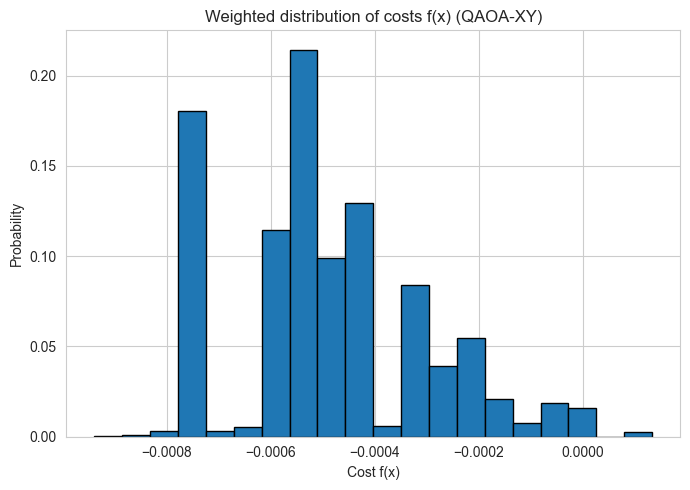

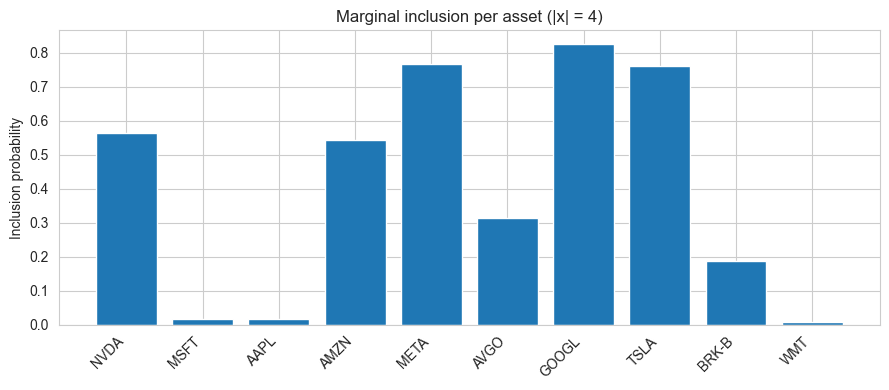

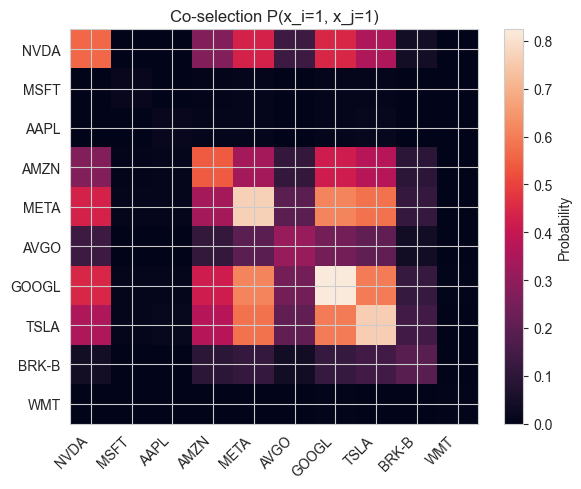

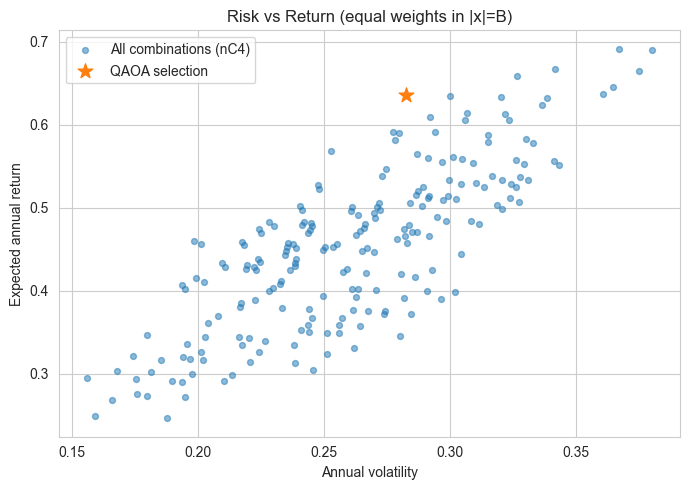

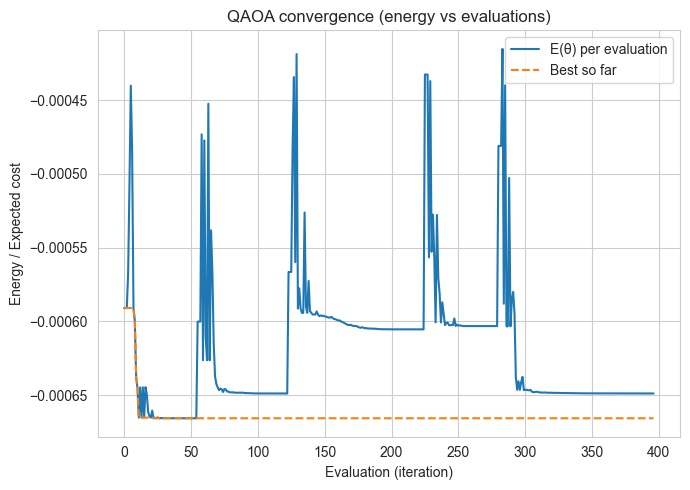


[Circuit complexity]
Qubits: 10, Layers p: 2, Parameters: 4
Pre-transpile -> depth: 62, size: 154, ops: {'rzz': 90, 'rz': 20, 'rxx': 20, 'ryy': 20, 'x': 4}
Post-transpile -> depth: 63, size: 160, ops: {'rzz': 90, 'rxx': 20, 'ryy': 20, 'rz': 16, 'measure': 10, 'u3': 4, 'barrier': 1}
Times -> Optimization: 5.31s | Sampling: 0.02s


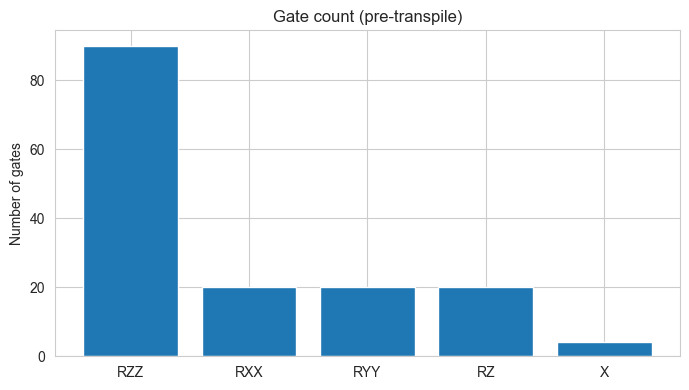


[Distribution of results |x|=B] Entropy: 2.9526 nats | Effective sample size: 12.3


In [24]:
# VISUALIZATION BLOCK
# Build DataFrame of samples (only |x|=B) ---
rows = []
total_shots = sum(counts.values())
for s, c in counts.items():
    x = bitarray_from_qiskit_string(s)
    if x.sum() != B:
        continue
    prob = c / total_shots
    cost = f_qubo(x)
    idx = np.where(x == 1)[0]
    tickers = [TICKERS[i] for i in idx]
    rows.append({
        "bitstring_qiskit_le": s,
        "shots": c,
        "prob": prob,
        "cost": cost,
        "indices": idx,
        "tickers": ", ".join(tickers)
    })
samples_df = pd.DataFrame(rows).sort_values(["prob", "cost"], ascending=[False, True]).reset_index(drop=True)

# --- 1) Histogram of costs weighted by probability ---
plt.figure(figsize=(7,5))
plt.hist(samples_df["cost"], bins=20, weights=samples_df["prob"], edgecolor="black")
plt.xlabel("Cost f(x)")
plt.ylabel("Probability")
plt.title("Weighted distribution of costs f(x) (QAOA-XY)")
plt.tight_layout()
plt.show()

# --- 2) Marginal inclusion probability per asset ---
p_incl = np.zeros(n)
for _, r in samples_df.iterrows():
    idx = np.array(r["indices"], dtype=int).reshape(-1)
    x = np.zeros(n)
    x[idx] = 1
    p_incl += r["prob"] * x

plt.figure(figsize=(9,4))
plt.bar(TICKERS, p_incl)
plt.ylabel("Inclusion probability")
plt.title(f"Marginal inclusion per asset (|x| = {B})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- 3) Co-selection heatmap P(x_i=1, x_j=1) ---
P_ij = np.zeros((n, n))
for _, r in samples_df.iterrows():
    idx = np.array(r["indices"], dtype=int).reshape(-1)
    for i in idx:
        for j in idx:
            P_ij[i, j] += r["prob"]

plt.figure(figsize=(6,5))
plt.imshow(P_ij, aspect='auto')
plt.xticks(range(n), TICKERS, rotation=45, ha="right")
plt.yticks(range(n), TICKERS)
plt.title("Co-selection P(x_i=1, x_j=1)")
plt.colorbar(label="Probability")
plt.tight_layout()
plt.show()

# --- 4) Risk-Return: all combinations C(n,B) vs QAOA selection ---
from itertools import combinations
def metrics_for_indices(sel_idx):
    idx = np.array(sel_idx, dtype=int).reshape(-1)
    w = np.zeros(n)
    w[idx] = 1.0 / B
    mu_day = float(mu @ w)
    var_day = float(w @ Sigma @ w)
    mu_ann = 252 * mu_day
    std_ann = np.sqrt(252 * var_day)
    return mu_ann, std_ann

all_mu, all_std = [], []
for comb in combinations(range(n), B):  # nCk (for n=10, B=4 => 210)
    m, s = metrics_for_indices(comb)
    all_mu.append(m)
    all_std.append(s)

qaoa_mu, qaoa_std = metrics_for_indices(sel_idx)

plt.figure(figsize=(7,5))
plt.scatter(all_std, all_mu, s=18, alpha=0.5, label=f"All combinations (nC{B})")
plt.scatter([qaoa_std], [qaoa_mu], s=120, marker="*", label="QAOA selection", zorder=3)
plt.xlabel("Annual volatility")
plt.ylabel("Expected annual return")
plt.title("Risk vs Return (equal weights in |x|=B)")
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) QAOA convergence: energy vs evaluations ---
if len(qaoa_trace) > 0:
    y = np.array(qaoa_trace, dtype=float)
    best_so_far = np.minimum.accumulate(y)
    plt.figure(figsize=(7,5))
    plt.plot(y, label="E(θ) per evaluation")
    plt.plot(best_so_far, linestyle="--", label="Best so far")
    plt.xlabel("Evaluation (iteration)")
    plt.ylabel("Energy / Expected cost")
    plt.title("QAOA convergence (energy vs evaluations)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No energy trace recorded.")

# --- 6) Circuit complexity: size, depth, gates ---
bound_circ = bind_params(ansatz, {p: float(t) for p, t in zip(theta_params, best_theta)})
pre_depth = bound_circ.depth()
pre_size  = bound_circ.size()
pre_ops   = bound_circ.count_ops()

tqc = transpile(bound_circ.measure_all(inplace=False) or bound_circ, backend)  # simple pass
post_depth = tqc.depth()
post_size  = tqc.size()
post_ops   = tqc.count_ops()

print("\n[Circuit complexity]")
print(f"Qubits: {n}, Layers p: {P_LAYERS}, Parameters: {2*P_LAYERS}")
print(f"Pre-transpile -> depth: {pre_depth}, size: {pre_size}, ops: {dict(pre_ops)}")
print(f"Post-transpile -> depth: {post_depth}, size: {post_size}, ops: {dict(post_ops)}")
print(f"Times -> Optimization: {(t1_opt - t0_opt):.2f}s | Sampling: {(t1_samp - t0_samp):.2f}s")

labels, vals = [], []
for k in ["rzz", "rxx", "ryy", "rz", "x"]:
    if k in pre_ops:
        labels.append(k.upper()); vals.append(int(pre_ops[k]))
if labels:
    plt.figure(figsize=(7,4))
    plt.bar(labels, vals)
    plt.title("Gate count (pre-transpile)")
    plt.ylabel("Number of gates")
    plt.tight_layout()
    plt.show()

# --- 7) Distribution measures ---
probs = samples_df["prob"].values
eps = 1e-16
entropy = -np.sum(np.where(probs > 0, probs * np.log(probs + eps), 0.0))
ess = 1.0 / np.sum((probs + eps)**2)
print(f"\n[Distribution of results |x|=B] Entropy: {entropy:.4f} nats | Effective sample size: {ess:.1f}")


# QUBO Brute-force solution and comparison


[Comparison]
Brute-Force optimum f(x) = -0.001044, Sharpe = 2.318
QAOA result     f(x) = -0.000940, Sharpe = 2.251


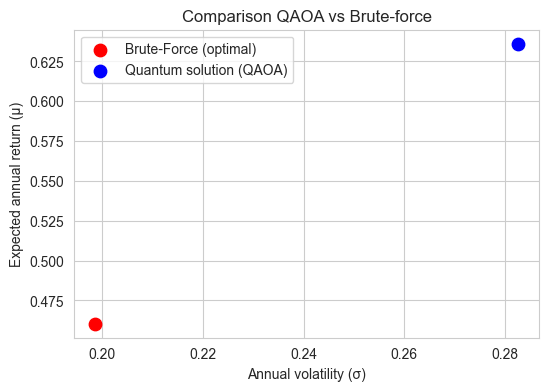

In [26]:
from itertools import combinations

# --- Classical brute-force search ---
best_val = np.inf
best_x = None

for comb in combinations(range(n), B):
    x = np.zeros(n)
    x[list(comb)] = 1
    val = f_qubo(x)
    if val < best_val:
        best_val = val
        best_x = x.copy()

# Metrics for brute-force optimum
sel_idx_BF = np.where(best_x == 1)[0]
mu_ann_BF, std_ann_BF = metrics_for_indices(sel_idx_BF)
sharpe_BF = mu_ann_BF / std_ann_BF

# Metrics for QAOA result
mu_ann_QAOA, std_ann_QAOA = metrics_for_indices(sel_idx)
sharpe_QAOA = mu_ann_QAOA / std_ann_QAOA

print("\n[Comparison]")
print(f"Brute-Force optimum f(x) = {best_val:.6f}, Sharpe = {sharpe_BF:.3f}")
print(f"QAOA result     f(x) = {fx_best:.6f}, Sharpe = {sharpe_QAOA:.3f}")



plt.figure(figsize=(6,4))
plt.scatter(std_ann_BF, mu_ann_BF, color='red', label='Brute-Force (optimal)', s=80)
plt.scatter(std_ann_QAOA, mu_ann_QAOA, color='blue', label='Quantum solution (QAOA)', s=80)
plt.xlabel("Annual volatility (σ)")
plt.ylabel("Expected annual return (μ)")
plt.title('Comparison QAOA vs Brute-force')
plt.legend()
plt.grid(True)
plt.show()